In [2]:


from numpy.random import seed
seed(1)



# Dependencies

http://www.gutenberg.org/cache/epub/621/pg621.txt


http://colah.github.io/posts/2015-08-Understanding-LSTMs/

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

#Sofmax bottleneck and RNN / high rank matrix problem in natural language processing
https://arxiv.org/pdf/1711.03953.pdf

https://www.jessicayung.com/using-generators-in-python-to-train-machine-learning-models/


In [3]:
from __future__ import print_function
import tensorflow
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Input, Embedding, GRU, Flatten
from tensorflow.keras import Model

import time
import numpy as np
import sys
import io
import os
import codecs
import random
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

# Constants and file paths

In [25]:
SEQUENCE_LEN = 10
MIN_WORD_FREQUENCY = 10
STEP = 1
BATCH_SIZE = 512

##########
#The data
##########
#corpus = r".\corpora\bible_lite.txt" # Bible
corpus = r".\corpora\bible.txt" # Bible

##########
#WHere the data goes
##########
examples = r".\output\examples.txt"
vocabulary = r".\output\vocab.txt"
checkpoint_path = r".\output\checkpoints"

# Functions

## Load and Clean


In [26]:
class TextData():
    def __init__(self):
        self.text = None
        self.tokens = None
        self.token_freq = None
        pass
    
    def load_corpus(self, corpus_file):
        """Takes a corpus filename, opens a utf-8 file, """
        with io.open(corpus_file, encoding='utf-8') as f:
            self.text = f.read().lower().replace('\n', ' \n ')
            print('Corpus length in characters:', len(self.text))
        return self.text

    def tokenize(self):
        self.tokens = [w for w in self.text.split(' ') if w.strip() != '' or w == '\n']
        print('Corpus length in words:', len(self.tokens))
        return self.tokens
    
    def get_token_freq(self):
        # Calculate word frequency
        self.token_freq = {}
        for token in self.tokens:
            self.token_freq[token] =  self.token_freq.get(token, 0) + 1
        return self.token_freq


## Sample w/ Temperature

In [27]:

def sample(preds, temperature=1.0):
    # Functions from keras-team/keras/blob/master/examples/lstm_text_generation.py
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


## Feature Selection

In [28]:
def get_ignorable_words(word_freq):
    ignored_words = set()
    for k, v in word_freq.items():
        if word_freq[k] < MIN_WORD_FREQUENCY:
            ignored_words.add(k)
    return ignored_words


def get_words(text_in_words, ignored_words):
    words = set(text_in_words)
    print('Unique words before ignoring:', len(words))
    print('Ignoring words with frequency <', MIN_WORD_FREQUENCY)
    words = sorted(set(words) - ignored_words)
    print('Unique words after ignoring:', len(words))
    return words

## Encoder/Decoder Tables + Chunk Training Data

In [29]:
def get_translate_dicts(words):
    word_indices = dict((c, i) for i, c in enumerate(words))
    indices_word = dict((i, c) for i, c in enumerate(words))
    return word_indices, indices_word


def get_training_data(text_in_words, ignored_words):
    # cut the text in semi-redundant sequences of SEQUENCE_LEN words
    sentences = []
    next_words = []
    ignored = 0
    for i in range(0, len(text_in_words) - SEQUENCE_LEN, STEP):
        # Only add the sequences where no word is in ignored_words
        if len(set(text_in_words[i: i+SEQUENCE_LEN+1]).intersection(ignored_words)) == 0:
            sentences.append(text_in_words[i: i + SEQUENCE_LEN])
            next_words.append(text_in_words[i + SEQUENCE_LEN])
        else:
            ignored = ignored + 1
    print('Ignored sequences:', ignored)
    print('Remaining sequences:', len(sentences))
    return sentences, next_words


## Keras Model Definition

In [30]:
def build_bi_lstm_model(n_cells = 128, dropout=0.2):
    print('Build model...')
    M = Sequential()
    M.add(Bidirectional(LSTM(n_cells), input_shape=(SEQUENCE_LEN, len(words))))
    if dropout > 0:
        M.add(Dropout(dropout))
    M.add(Dense(len(words), activation = 'softmax'))
    return M

def build_lstm_model(n_cells = 128, dropout=0.2):
    print('Build model...')
    M = Sequential()
    M.add(LSTM(n_cells, input_shape=(SEQUENCE_LEN, len(words))))
    if dropout > 0:
        M.add(Dropout(dropout))
    M.add(Dense(len(words), activation = 'softmax'))
    return M
          
def build_gru_model(n_cells = 128, dropout=0.2):
    print('Build model...')
    M = Sequential()
    M.add(GRU(n_cells, input_shape=(SEQUENCE_LEN, len(words))))
    if dropout > 0:
        M.add(Dropout(dropout))
    M.add(Dense(len(words),  activation = 'softmax'))
    return M

## Log Vocabulary

In [31]:
def log_vocabulary(words_file_path, words_set):
    """Takes a filepath and a list, and creates a text file to log that word list"""
    words_file = codecs.open(words_file_path, 'w', encoding='utf8')
    for w in words_set:
        if w != "\n":
            words_file.write(w+"\n")
        else:
            words_file.write(w)
    words_file.close()




## Keras Callbacks

In [32]:

#For lambda callback
def generate_early_predictions(epoch, logs = None):
    examples_file.write('\n----- Generating text after Epoch: %d\n' % epoch)

    # Randomly pick a seed sequence from the existing data
    seed_index = np.random.randint(len(X_train+X_test))
    seed_sentence = (X_train+X_test)[seed_index]

    for diversity in [0.3, 0.4, 0.5, 0.6, 0.7]:


        examples_file.write('----- Diversity:' + str(diversity) + '\n')
        examples_file.write('----- Generating with seed:\n"' + ' '.join(seed_sentence) + '"\n')
        examples_file.write(' '.join(seed_sentence))

        for i in range(50):
            x_pred = np.zeros((1, SEQUENCE_LEN, len(words)))
            for t, word in enumerate(seed_sentence):
                x_pred[0, t, ENCODER_TABLE[word]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_word = DECODER_TABLE[next_index]

            sentence = seed_sentence[1:]
            sentence.append(next_word)

            examples_file.write(" "+next_word)
        examples_file.write('\n')
    examples_file.write('='*80 + '\n')
    examples_file.flush()
    
  

class TimeHistory(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


## Plotting

In [33]:

def plot_confusion_matrix(y_true,y_pred):
    fig = plt.figure(figsize=(5,5))
    matrix = confusion_matrix(y_true, y_pred)
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    #plt.matshow(conf_mx, cmap=plt.cm.gray)
    plt.xlabel("Predicted Classes")
    plt.ylabel("Actual Classes")
    # plt.savefig("confusion_matrix_plot_mnist", tight_layout=False)
    plt.show()
    

def plot_history(history_log):
    plt.style.use('ggplot')
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(17,5))
    ax1.plot(history_log['val_accuracy'], label = 'val')
    ax1.plot(history_log['accuracy'], label = 'train')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    #ax1.grid()
    ax1.legend()
    ax2.plot(history_log['val_loss'], label = 'val')
    ax2.plot(history_log['loss'], label = 'train')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss (softmax)')
    #ax2.grid()
    ax2.legend()

## Data Generator/Encoder for Training and predictions

In [34]:
def generator(X, y, ENCODER_TABLE, words, batch_size):#sentence_list, next_word_list, batch_size):
    index = 0
    while True:
        
        #Chunks of data to return
        X_ = np.zeros((batch_size, SEQUENCE_LEN, len(words)), dtype=np.bool)
        y_ = np.zeros((batch_size, len(words)), dtype=np.bool)
        
        #Chunk iterator
        for chunk in range(batch_size):
            for t, w in enumerate(X[index % len(X)]):
                #2D Edit Container
                 X_[chunk, t, ENCODER_TABLE[w]] = 1
            #Edit Container
            y_[chunk, ENCODER_TABLE[y[index % len(X)]]] = 1
            index = index + 1
        yield X_, y_


# Main

## Obtain data

We load the corpus



In [35]:
data = TextData()

In [36]:
text = data.load_corpus(corpus)

text[500:1000]

Corpus length in characters: 4552748


'******** \n  \n  \n this ebook is for the use of anyone anywhere at no cost and with \n almost no restrictions whatsoever.  you may copy it, give it away or \n re-use it under the terms of the project gutenberg license included \n with this ebook or online at www.gutenberg.org \n  \n  \n title: the king james bible \n  \n release date: march 2, 2011 [ebook #10] \n [this king james bible was orginally posted by project gutenberg \n in late 1989] \n  \n language: english \n  \n  \n *** start of this project gutenbe'

In [37]:
list_of_tokens = data.tokenize()
list_of_tokens[:15]

Corpus length in words: 924423


['\ufeffthe',
 'project',
 'gutenberg',
 'ebook',
 'of',
 'the',
 'king',
 'james',
 'bible',
 '\n',
 '\n',
 '\n',
 '**********************************************************************',
 '\n',
 'ebook']

In [38]:
token_freq = data.get_token_freq()
token_freq['lord']

4739

In [39]:
ignored_words = get_ignorable_words(token_freq)
random.sample(ignored_words, 10)

['secret:',
 'delectable',
 'fortified',
 'interpretations',
 'valiantly:',
 '19:43',
 '51:64',
 'meats?',
 '37:21',
 '69:13']

In [40]:
len(ignored_words)

27010

In [41]:
words = get_words(list_of_tokens, ignored_words)
words[:5]

Unique words before ignoring: 32712
Ignoring words with frequency < 10
Unique words after ignoring: 5702


['\n', '(and', '(for', '(now', '10:1']

In [43]:
log_vocabulary(vocabulary, words)

In [44]:
ENCODER_TABLE, DECODER_TABLE = get_translate_dicts(words)
print("Encoder Table:\n",list(ENCODER_TABLE.items())[:10],"\nDecoder Table:\n", list(DECODER_TABLE.items())[:10])

Encoder Table:
 [('\n', 0), ('(and', 1), ('(for', 2), ('(now', 3), ('10:1', 4), ('10:10', 5), ('10:11', 6), ('10:12', 7), ('10:13', 8), ('10:14', 9)] 
Decoder Table:
 [(0, '\n'), (1, '(and'), (2, '(for'), (3, '(now'), (4, '10:1'), (5, '10:10'), (6, '10:11'), (7, '10:12'), (8, '10:13'), (9, '10:14')]


In [45]:
sentences, next_words = get_training_data(list_of_tokens, ignored_words)

for i in range(10):
    print(f"Sentence: {sentences[i]} \n---Prediction: {next_words[i]}")


Ignored sequences: 483752
Remaining sequences: 440661
Sentence: ['\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n'] 
---Prediction: 

Sentence: ['\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n'] 
---Prediction: 

Sentence: ['\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n'] 
---Prediction: 

Sentence: ['\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n'] 
---Prediction: 

Sentence: ['\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n'] 
---Prediction: 

Sentence: ['\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n'] 
---Prediction: the
Sentence: ['\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', 'the'] 
---Prediction: old
Sentence: ['\n', '\n', '\n', '\n', '\n', 'the', 'first', 'book', 'of', 'moses:'] 
---Prediction: called
Sentence: ['\n', '\n', '\n', '1:1', 'in', 'the', 'beginning', 'god', 'created', 'the'] 
---Prediction: heaven
Sentence: ['\n', '\n', '1:1', 'in', 'the', 'beginning', 'god', 'created', 'the', 'heaven'] 
---Predictio

# (Optional) Embedding Layer


In [46]:

# GLOVE_DIR = './'
# EMBEDDING_DIM = 50

# embeddings_index = {}
# f = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'), encoding = 'utf-8')
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

# print('Found %s word vectors.' % len(embeddings_index))



# embedding_matrix = np.zeros((len(ENCODER_TABLE) + 1, EMBEDDING_DIM))
# for word, i in ENCODER_TABLE.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # words not found in embedding index will be all-zeros.
#         embedding_matrix[i] = embedding_vector

        
# from tensorflow.keras.layers import Embedding

# embedding_layer = Embedding(len(ENCODER_TABLE) + 1,
#                             EMBEDDING_DIM,
#                             weights=[embedding_matrix],
#                             input_length=SEQUENCE_LEN,
#                             trainable=False)

# Experiment Modeling

## Data Setup

In [47]:
 X_train, X_test, y_train,y_test = train_test_split(
        sentences, next_words, shuffle = True, test_size = .1)

## Callbacks

In [48]:
checkpoint = ModelCheckpoint(checkpoint_path) #Creates intermittent saves
print_callback = LambdaCallback(on_epoch_end=generate_early_predictions) #Prints intermittent example hallucinations to file
early_stopping = EarlyStopping(monitor='val_accuracy', patience=4) #Early stopping needed
th = TimeHistory()

callbacks_list = [checkpoint, print_callback, early_stopping,th] #List of callbacks

## Model

In [49]:
n_cells = 128 #How many LSTM Cells


#Model Building
#model = build_bi_lstm_model(n_cells)
model = build_gru_model(n_cells)
#model = build_lstm_model(n_cells)


#Compile
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

Build model...


# Fit


In [50]:
#Open up a file to write in during training
examples_file = open(examples, "w")


history = model.fit(generator(X_train, y_train, ENCODER_TABLE, words, BATCH_SIZE),
                    steps_per_epoch=int(len(X_train)/BATCH_SIZE) + 1,
                    epochs=15,
                    callbacks=callbacks_list,
                    validation_data=generator(X_test, y_test, ENCODER_TABLE, words, BATCH_SIZE),
                    validation_steps=int(len(X_test)/BATCH_SIZE) + 1)

# #Save the model
# model.save('model_notebook.h5')
#Save the model
model_save_path = r'./output/model_notebook_gru_weights.h5'
model.save(model_save_path)


# #Dump the history 
# with open('history_notebook.txt', 'w') as f:
#     f.write(json.dumps(history.history))
#Dump the history 
history_save_path = r'./output/history_gru_notebook_test.txt'
with open(history_save_path, 'w') as f:
    f.write(json.dumps(history.history))
 




Epoch 1/15
 58/775 [=>............................] - ETA: 4:31 - loss: 7.0059 - accuracy: 0.0930

KeyboardInterrupt: 

In [201]:
time

<module 'time' (built-in)>

# Analysis

In [235]:


# model_file = r".\model_notebook.h5"
# history_file = r".\history_notebook.txt"
# model_file = r".\model_notebook_test.h5"
# history_file = r".\history_notebook_test.txt"
model_file = model_save_path
model_file = r'./model.h5'
history_file = history_save_path
history_file = r'./history.txt'



In [236]:
df = pd.DataFrame(token_freq, index = [0])
df

,﻿the,project,gutenberg,ebook,of,the,king,james,bible,\n,...,included.,necessarily,edition.,main,pg,facility:,http://www.gutenberg.org,includes,"gutenberg-tm,",newsletter
0,1,84,25,11,34755,64193,1799,29,8,100231,...,1,1,1,1,1,1,1,1,1,1


## Log of the word frequency


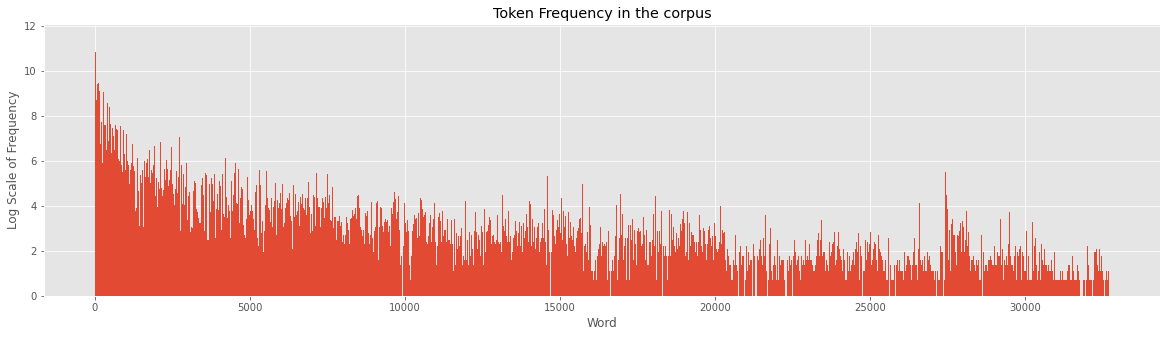

In [233]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20,5));
ax.bar(range(len(df.columns)),np.log(df.iloc[0].values), width = 13);
ax.set_title('Token Frequency in the corpus');
ax.set_ylabel('Log Scale of Frequency');
ax.set_xlabel('Word');


## Loss and Accuracy

In [238]:
with open(history_file, 'r') as f:
    training_data = json.loads(f.read())
training_df = pd.DataFrame(training_data)
training_df

,loss,accuracy,val_loss,val_accuracy
0,5.776847,0.137603,5.340883,0.207357
1,4.957626,0.233493,4.594858,0.260525
2,4.405761,0.269395,4.285929,0.279514
3,4.117078,0.286691,4.110016,0.287869
4,3.911716,0.301103,4.013941,0.297092
5,3.747556,0.313310,3.966613,0.299262
6,3.608217,0.325593,3.907731,0.301324
7,3.480587,0.336042,3.906404,0.304145
8,3.361107,0.346735,3.894507,0.302300
9,3.251452,0.358028,3.912847,0.302517


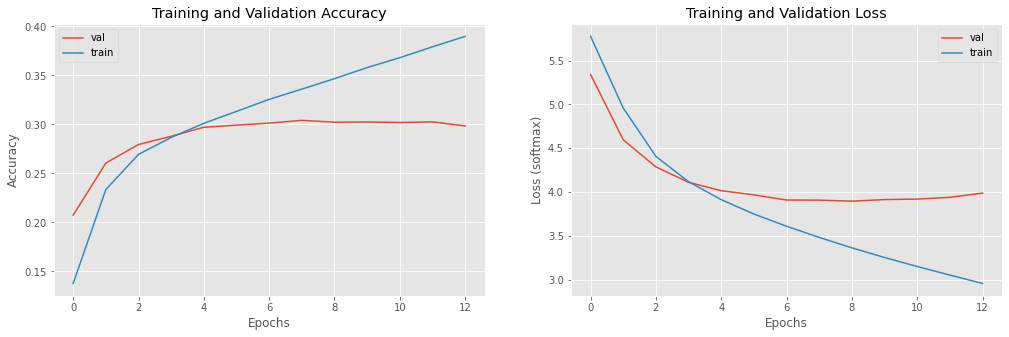

In [239]:
plot_history(training_df)


In [241]:
offline_model = load_model(model_file)
for l in offline_model.layers:
    print(l, len(l.get_weights()))

<tensorflow.python.keras.layers.wrappers.Bidirectional object at 0x0000023EAEB76D90> 6
<tensorflow.python.keras.layers.core.Dropout object at 0x0000023EAEB7C2B0> 0
<tensorflow.python.keras.layers.core.Dense object at 0x0000023EAEB7C940> 2
<tensorflow.python.keras.layers.core.Activation object at 0x0000023EAE0E92E0> 0


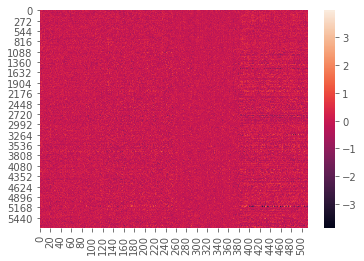

In [246]:
dense = offline_model.layers[-4].get_weights()[0]
sns.heatmap(dense)

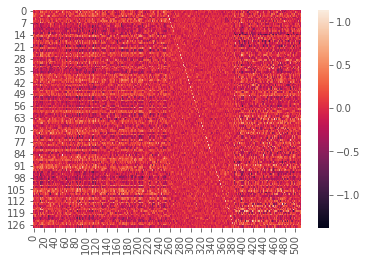

In [247]:
dense = offline_model.layers[-4].get_weights()[1]
sns.heatmap(dense)

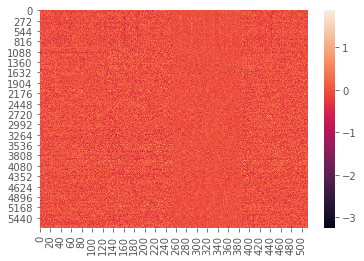

In [263]:
dense = offline_model.layers[-4].get_weights()[3]
sns.heatmap(dense)

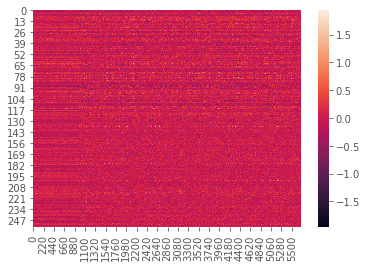

In [264]:
dense = offline_model.layers[-2].get_weights()[0]
sns.heatmap(dense)

## Prediction Microscope

In [47]:
def p_generator(X, ENCODER_TABLE, words, batch_size):#sentence_list, next_word_list, batch_size):
    index = 0
    while True:
        
        #Chunks of data to return
        X_ = np.zeros((batch_size, SEQUENCE_LEN, len(words)), dtype=np.bool)
        #y_ = np.zeros((batch_size, len(words)), dtype=np.bool)
        
        #Chunk iterator
        for chunk in range(batch_size):
            for t, w in enumerate(X[index % len(X)]):
                #2D Edit Container
                 X_[chunk, t, ENCODER_TABLE[w]] = 1
            #Edit Container
            #y_[chunk, ENCODER_TABLE[y[index % len(X)]]] = 1
            index = index + 1
        yield X_#, y_


In [48]:
def validate_with_test_set(sentence, model, diversity = 1):
    for _ in range(1):
        x_pred = np.zeros((1, SEQUENCE_LEN, len(words)))
        for t, word in enumerate(sentence):
            x_pred[0, t, ENCODER_TABLE[word]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]

        next_index = sample(preds, diversity)
        next_word = DECODER_TABLE[next_index]
        print(sentence)
        print()
        print(next_word)
    return preds


In [49]:
offline_model = load_model(model_file)

In [50]:
p = validate_with_test_set(X_test[2],offline_model)
print('Answer:', y_test[2])


['which', 'is', 'upon', 'the', 'face', 'of', 'all', 'the', 'earth,', 'and']

him,
Answer: every


In [116]:
output_fps = ['./output/history_gru_notebook_test.txt', 
             './output/history_lstm_notebook_test.txt',
            './output/history_bilstm_notebook_test.txt']

output_fps = ['./output/history_gru_notebook_test.txt', 
             './output/history_lstm_notebook_test.txt',
            './output/history_bilstm_notebook_test.txt']

In [117]:
dfs_to_concat = []
for fp in output_fps:
    with open(fp, 'r') as f:
        training_data = json.loads(f.read())
    training_df = pd.DataFrame(training_data)
    dfs_to_concat.append(training_df)

In [126]:
results_df = pd.concat(dfs_to_concat)
_ = str('bilstm|'*8)+str('lstm|'*8)+str('gru|'*8)#.split('|')[:-1]
results_df['model'] = _.split('|')[:-1]

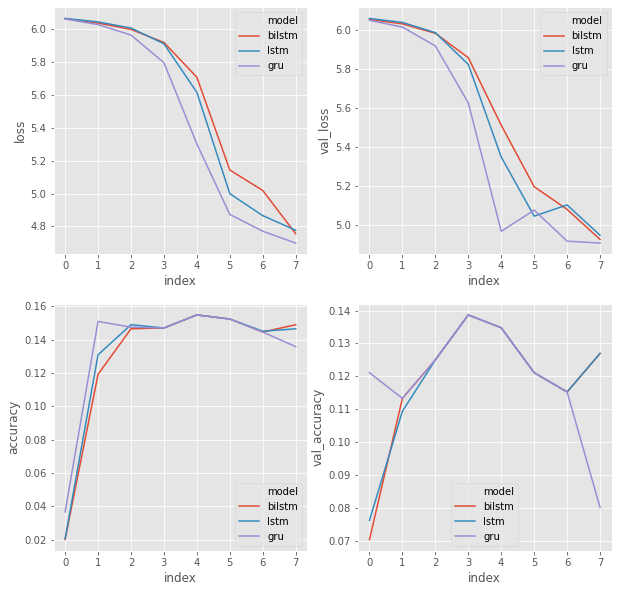

In [160]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))
ax1, ax2, ax3, ax4 = axes.flatten()
sns.lineplot('index', 'loss', data = results_df.reset_index(), hue = 'model', ax = ax1)
sns.lineplot('index', 'val_loss', data = results_df.reset_index(), hue = 'model',ax = ax2)
sns.lineplot('index', 'accuracy', data = results_df.reset_index(), hue = 'model',ax = ax3)
sns.lineplot('index', 'val_accuracy', data = results_df.reset_index(), hue = 'model',ax = ax4)

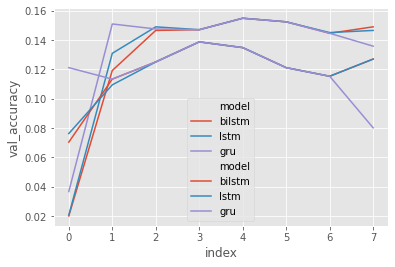

In [156]:
sns.lineplot('index', 'accuracy', data = results_df.reset_index(), hue = 'model')
sns.lineplot('index', 'val_accuracy', data = results_df.reset_index(), hue = 'model')

# Weights

In [173]:
offline_gru_model = load_model('./output/model_notebook_gru_weights.h5')


gru_weights = offline_gru_model.layers[-3].get_weights()

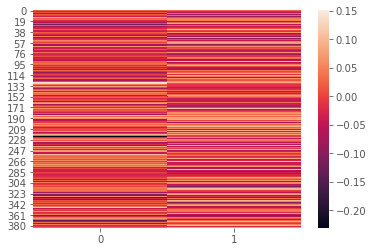

In [200]:
gru_weights[1][0,:].shape
gru_weights[0][0,:].shape
sns.heatmap(np.c_[gru_weights[1][0,:], gru_weights[0][0,:]])

#  Predictions

In [205]:
def validate_seed(words, seed):
    """Validate that all the words in the seed are part of the vocabulary"""
    print("\nValidating that all the words in the seed are part of the vocabulary: ")
    seed_words = seed.split(" ")
    valid = True
    for w in seed_words:
        print(w, end="")
        if w in words:
            print(" ✓ in vocabulary")
        else:
            print(" ✗ NOT in vocabulary")
            valid = False
    return valid

def generate_text(model_file, indices_word, word_indices, seed,
                  sequence_length, diversity = .5, quantity = 50):
    model = load_model(model_file)
    model.compile(loss='categorical_crossentropy', optimizer="adam")
    print("\nSummary of the Network: ")
    model.summary()

    sentence = seed.split(" ")
    print("----- Generating text")
    print('----- Diversity:' + str(diversity))
    print(f'----- Generating with seed:"{seed}"\n------\n' )

    for _ in range(quantity):
        x_pred = np.zeros((1, sequence_length, len(words)))
        for t, word in enumerate(sentence):
            x_pred[0, t, word_indices[word]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]

        next_index = sample(preds, diversity)
        next_word = indices_word[next_index]

        sentence = sentence[1:]
        sentence.append(next_word)

        print(" "+next_word, end="")
    print("\n")

def hallucinate(words, seed):
    if validate_seed(words, seed):
        print("\nSeed is correct.\n")
        # repeat the seed in case is not long enough, and take only the last elements
        seed = " ".join((((seed+" ")*SEQUENCE_LEN)+seed).split(" ")[-SEQUENCE_LEN:])
        
        
        generate_text(model_file, DECODER_TABLE, ENCODER_TABLE, seed, SEQUENCE_LEN, .5, 50)
    else:
        print('Provide a different seed seed...')

In [206]:
seed = "he said that this will come to the earth when"
hallucinate(words,seed)


Validating that all the words in the seed are part of the vocabulary: 
he ✓ in vocabulary
said ✓ in vocabulary
that ✓ in vocabulary
this ✓ in vocabulary
will ✓ in vocabulary
come ✓ in vocabulary
to ✓ in vocabulary
the ✓ in vocabulary
earth ✓ in vocabulary
when ✓ in vocabulary

Seed is correct.


Summary of the Network: 
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 128)               216192    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 433)               55857     
Total params: 272,049
Trainable params: 272,049
Non-trainable params: 0
_________________________________________________________________
----- Generating text
----- Diversity:0.5
----- Generat

In [92]:
def rand_seed_corp():
    #Randomly pick a seed sequence from the existing data
    seed_index = np.random.randint(len(X_train+X_test))
    seed_sentence = (X_train+X_test)[seed_index]
    return seed_sentence

' '.join(rand_seed_corp())


'dwelt ten years in the land of canaan, and gave'

In [93]:
for i in range(5):
    s = ' '.join(rand_seed_corp())
    hallucinate(words,s)


Validating that all the words in the seed are part of the vocabulary: 
said, ✓ in vocabulary
let ✓ in vocabulary
me, ✓ in vocabulary
i ✓ in vocabulary
pray ✓ in vocabulary
thee, ✓ in vocabulary

 ✓ in vocabulary
drink ✓ in vocabulary
a ✓ in vocabulary
little ✓ in vocabulary

Seed is correct.


Summary of the Network: 
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 256)               575488    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 433)               111281    
Total params: 686,769
Trainable params: 686,769
Non-trainable params: 0
_________________________________________________________________
----- Generating text
----- Diversity:0.5
----- Generatin

# WIP


## Embedding

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/#:~:text=Keras%20Embedding%20Layer,API%20also%20provided%20with%20Keras.

In [164]:
offline_model.layers

## Weights Exploration

In [ ]:
softmax_layer = offline_model.layers[-2].get_weights()

In [ ]:
softmax_layer_weights= softmax_layer[1]
print(f"Shape of Softmax Layer: {softmax_layer_weights.shape}")

In [ ]:
import matplotlib.pyplot as plt
plt.hist(softmax_layer_weights[softmax_layer_weights>0])

In [220]:
X_train[0]

['they',
 'heard',
 'a',
 'great',
 'voice',
 'from',
 'heaven',
 'saying',
 'unto',
 'them,']

## Understanding the dimensions

In [169]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


x_train[0]
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=2,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...
Train...


c:\users\jamespc\source\repos\lstm\lstm_lyrics\env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 110s 4ms/step - loss: 0.4598 - accuracy: 0.7828 - val_loss: 0.3732 - val_accuracy: 0.8356
Epoch 2/2
25000/25000 [==============================] - 19s 763us/step
Test score: 0.39612588248252867
Test accuracy: 0.8277599811553955


In [183]:
from sklearn.decomposition import PCA

p = PCA(n_components = 2)

p_ = p.fit_transform(model.layers[-3].get_weights()[0])
p_

array([[-0.08037307, -0.4063899 ],
       [-0.32095656, -0.6347006 ],
       [ 0.06528186, -0.13020153],
       ...,
       [ 0.2041394 , -0.11281364],
       [-0.38919097,  0.02323285],
       [-0.3775762 ,  0.11079376]], dtype=float32)

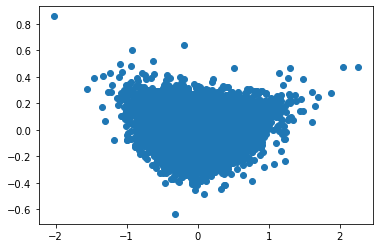

In [185]:
plt.scatter(p_[:,0], p_[:,1])